# 🐦 Twitter Sentiment Analysis in Spanish Tweets  

## 👥 Authors
- **Kristopher Javier Alvarado López** — Carné: 21188  
- **Emilio Jose Solano Orozco** — Carné: 21212  

---

## 📖 Project Description
Este proyecto consiste en el desarrollo de un **pipeline completo de Procesamiento de Lenguaje Natural (NLP)** aplicado a tweets en español.  
El objetivo es analizar el sentimiento expresado en los mensajes (positivo, negativo o neutro) integrando las siguientes etapas:  

1. **Preprocesamiento del texto**: limpieza, tokenización, lematización, normalización y corrección ortográfica.  
2. **Representación de texto**: Bag of Words (BoW), TF-IDF, matrices de co-ocurrencia y embeddings.  
3. **Modelos probabilísticos**: construcción de modelos N-gram y evaluación con entropía y perplejidad.  
4. **Modelos de clasificación**: aplicación de algoritmos supervisados para la detección automática de sentimiento.  
5. **Evaluación y discusión crítica** de resultados.  

---

## 🌍 English Abstract
This project presents the development of a **complete NLP pipeline** for sentiment analysis in Spanish tweets.  
The main goal is to evaluate different text preprocessing techniques, representation models, and machine learning approaches to classify tweets into sentiment categories (positive, negative, neutral). The project combines classical probabilistic language models with modern embedding-based techniques, offering a critical analysis of their performance on real-world social media data.


In [3]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("data/sentiment_analysis_dataset.csv")

# Vista rápida
print("Columnas originales:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)
df.head()


Columnas originales: ['user', 'text', 'date', 'emotion', 'sentiment']
Tamaño del dataset: (2590, 5)


,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [4]:
# Eliminar la columna 'sentiment'
df = df.drop(columns=["sentiment"])

# Revisar cambios
print("Columnas después de eliminar 'sentiment':", df.columns.tolist())
df.head()


Columnas después de eliminar 'sentiment': ['user', 'text', 'date', 'emotion']


,user,text,date,emotion
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed


# 🛠️ 1. Preprocesamiento del Corpus  

En esta sección realizamos el **preprocesamiento de los tweets en español** para preparar el corpus antes de aplicar modelos de NLP.  

Las tareas principales son:  

1. **Limpieza del texto**: conversión a minúsculas, eliminación de puntuación, URLs, menciones y stopwords.  
2. **Tokenización**: separación de cada oración en palabras.  
3. **Lematización y stemming**: reducción de palabras a su raíz o forma base.  
4. **Uso del algoritmo de Levenshtein**: detección de similitudes y posibles errores ortográficos en el texto.  

---

In [7]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Descargar stopwords (solo primera vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# 🔹 Función de limpieza
def clean_text(text):
    text = text.lower()  # minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URLs
    text = re.sub(r"@\w+", "", text)  # menciones
    text = re.sub(r"#\w+", "", text)  # hashtags
    text = re.sub(r"[^\w\s]", "", text)  # puntuación
    text = " ".join([word for word in text.split() if word not in stop_words])  # stopwords
    return text.strip()

# 🔹 Aplicar limpieza
df["clean_text"] = df["text"].astype(str).apply(clean_text)
df[["text", "clean_text"]].head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,termine bien abrumado después de hoy,termine bien abrumado después hoy
1,me siento abrumado,siento abrumado
2,Me siento un poco abrumado por la cantidad de ...,siento abrumado cantidad cosas quiero dibujar ...
3,Salvador la única persona que no la ha abrumad...,salvador única persona abrumado versiones
4,Denme un helado o algo que ando full abrumado.,denme helado ando full abrumado
5,"Estoy abrumado de airdrops , de youtube y de t...",abrumado airdrops youtube imposible gestionarl...
6,"#MicroCuento: A veces, sin motivo aparente, o,...",veces motivo aparente bien razones quizás fúti...
7,"Oh, las vacaciones. Tesoros inciertos, venider...",oh vacaciones tesoros inciertos venideros prec...
8,me siento muy abrumado,siento abrumado
9,Consejo que nadie pidió: Si un día te siente...,consejo nadie pidió si día sientes abrumado tr...


In [8]:
import stanza

# Descargar modelo de español (solo la primera vez)
stanza.download("es")

# Crear pipeline en español
nlp = stanza.Pipeline("es", processors="tokenize,lemma", use_gpu=False)

# Función para tokenizar y lematizar
def tokenize_lemmatize(text):
    doc = nlp(text)
    return [word.lemma for sent in doc.sentences for word in sent.words]

# Aplicar al corpus
df["lemmas"] = df["clean_text"].apply(tokenize_lemmatize)
df[["clean_text", "lemmas"]].head(10)


c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-02 03:04:01 INFO: Downloaded file to C:\Users\Usuario\stanza_resources\resources.json
2025-10-02 03:04:01 INFO: Downloading default packages for language: es (Spanish) ...
2025-10-02 03:05:57 INFO: Downloaded file to C:\Users\Usuario\stanza_resources\es\default.zip
2025-10-02 03:06:11 INFO: Finished downloading models and saved to C:\Users\Usuario\stanza_resources
2025-10-02 03:06:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-10-02 03:06:12 INFO: Downloaded file to C:\Users\Usuario\stanza_resources\resources.json
2025-10-02 03:06:12 WARNING: Language es package default expects mwt, which has b

,clean_text,lemmas
0,termine bien abrumado después hoy,"[terminar, bien, abrumado, después, hoy]"
1,siento abrumado,"[sentir, abrumado]"
2,siento abrumado cantidad cosas quiero dibujar ...,"[sentir, abrumado, cantidad, cosa, querer, dib..."
3,salvador única persona abrumado versiones,"[salvador, único, persona, abrumado, versión]"
4,denme helado ando full abrumado,"[denme, helado, ando, full, abrumado]"
5,abrumado airdrops youtube imposible gestionarl...,"[abrumado, airdrop, youtube, imposible, gestio..."
6,veces motivo aparente bien razones quizás fúti...,"[vez, motivo, aparente, bien, razón, quizás, f..."
7,oh vacaciones tesoros inciertos venideros prec...,"[oh, vacaciones, tesoro, incierto, venidero, p..."
8,siento abrumado,"[sentir, abrumado]"
9,consejo nadie pidió si día sientes abrumado tr...,"[consejo, nadie, pedir, si, día, sentir, abrum..."


In [12]:
import Levenshtein

# Función para calcular similitud normalizada
def levenshtein_sim(word1, word2):
    if not word1 or not word2:
        return 0
    return 1 - (Levenshtein.distance(word1, word2) / max(len(word1), len(word2)))

# Ejemplos de similitud
ejemplos = [("abrumado", "abrumao"),
            ("feliz", "felices"),
            ("hotel", "hostel"),
            ("bueno", "vueno")]

for w1, w2 in ejemplos:
    print(f"Similitud {w1} - {w2}: {levenshtein_sim(w1, w2):.2f}")


Similitud abrumado - abrumao: 0.88
Similitud feliz - felices: 0.57
Similitud hotel - hostel: 0.83
Similitud bueno - vueno: 0.80


In [13]:
from collections import Counter

# Obtener todas las palabras del corpus (lematizadas para más consistencia)
all_words = [lemma for tokens in df["lemmas"] for lemma in tokens]
word_freq = Counter(all_words)

# Seleccionar palabras poco frecuentes (candidatas a errores)
rare_words = [w for w, f in word_freq.items() if f == 1]

# Comparar rare_words con palabras frecuentes para sugerir similitud
frequent_words = [w for w, f in word_freq.items() if f > 5]

# Buscar rare_words similares a frequent_words
sugerencias = {}
for rw in rare_words[:20]:  # limitar a 20 para ejemplo
    for fw in frequent_words:
        if levenshtein_sim(rw, fw) > 0.8 and rw != fw:
            sugerencias[rw] = fw
            break

sugerencias


{'sobrecarga': 'sobrecargado'}

# ✍️ 2. Representación del Texto  

En esta sección se construyen diferentes representaciones vectoriales del corpus en español, para comparar su capacidad de capturar información semántica:  

1. **Bolsa de Palabras (BoW)** y **TF-IDF**: representaciones clásicas basadas en frecuencias.  
2. **Matriz de co-ocurrencia** y aplicación de **PPMI** para capturar relaciones entre palabras.  
3. **Embeddings**: representación densa mediante modelos como Word2Vec o FastText.  
4. **Visualización comparativa** de las representaciones con técnicas de reducción de dimensionalidad (PCA o t-SNE).  

---

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Usaremos el texto limpio
texts = df["clean_text"].astype(str).tolist()

# BoW
bow_vectorizer = CountVectorizer(max_features=2000)  # limitamos a 2000 palabras más frecuentes
X_bow = bow_vectorizer.fit_transform(texts)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

print("BoW shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)


BoW shape: (2590, 2000)
TF-IDF shape: (2590, 2000)


In [15]:
import numpy as np
from collections import defaultdict

# Crear vocabulario limitado
vectorizer = CountVectorizer(max_features=500, stop_words=list(stop_words))
X_counts = vectorizer.fit_transform(texts)
vocab = vectorizer.get_feature_names_out()

# Matriz de co-ocurrencia (ventana = 2)
window_size = 2
co_occurrence = np.zeros((len(vocab), len(vocab)))

for text in texts:
    tokens = text.split()
    for i, word in enumerate(tokens):
        if word in vocab:
            word_idx = np.where(vocab == word)[0][0]
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i != j and tokens[j] in vocab:
                    context_idx = np.where(vocab == tokens[j])[0][0]
                    co_occurrence[word_idx, context_idx] += 1

# Aplicar PPMI
total_sum = np.sum(co_occurrence)
word_freqs = np.sum(co_occurrence, axis=1)

ppmi = np.zeros_like(co_occurrence)
for i in range(len(vocab)):
    for j in range(len(vocab)):
        if co_occurrence[i, j] > 0:
            p_ij = co_occurrence[i, j] / total_sum
            p_i = word_freqs[i] / total_sum
            p_j = word_freqs[j] / total_sum
            value = np.log2(p_ij / (p_i * p_j))
            ppmi[i, j] = max(value, 0)

ppmi.shape


(500, 500)

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch

# cargar modelo BETO (BERT entrenado en español)
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# ejemplo: obtener embedding de una palabra
text = "Me siento abrumado"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# vector de la primera palabra
embedding = outputs.last_hidden_state[0][1].detach().numpy()
embedding[:10]


c:\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downlo

array([-0.51360893, -0.37982357, -0.23070341, -0.44034857,  0.22372913,
       -0.52043295, -0.251119  ,  0.56024027, -0.08720638, -0.01238056],
      dtype=float32)

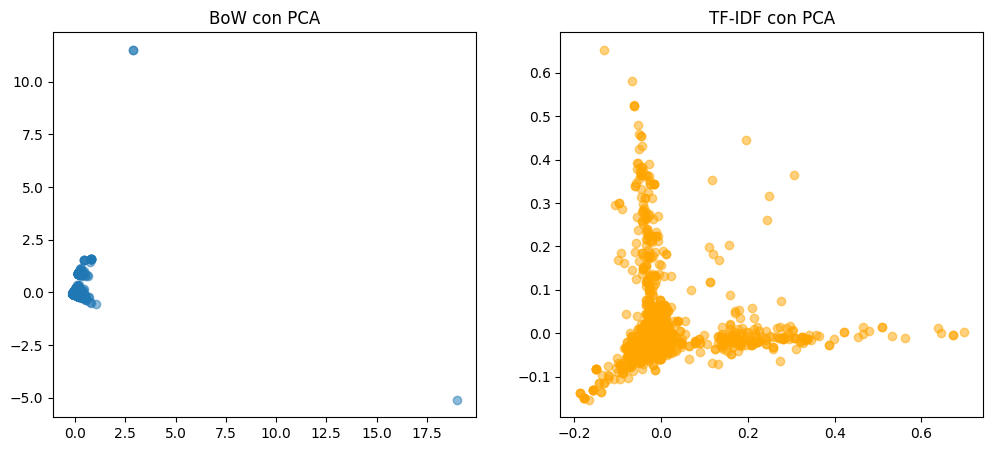

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2D con PCA
pca_bow = PCA(n_components=2).fit_transform(X_bow.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualizar
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pca_bow[:,0], pca_bow[:,1], alpha=0.5)
plt.title("BoW con PCA")

plt.subplot(1,2,2)
plt.scatter(pca_tfidf[:,0], pca_tfidf[:,1], alpha=0.5, color="orange")
plt.title("TF-IDF con PCA")

plt.show()


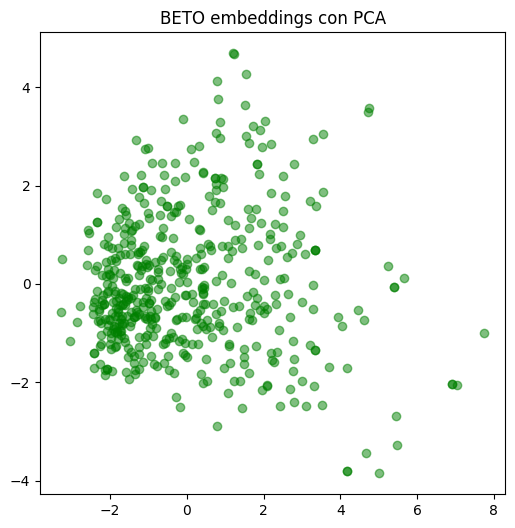

In [18]:
# Generar embeddings promedio de cada tweet
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
    outputs = model(**inputs)
    # vector promedio de todos los tokens
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# Calcular embeddings para un subconjunto de tweets (ej: 500 para que no tarde mucho)
subset = df["clean_text"].astype(str).sample(500, random_state=42).tolist()
embeddings = np.array([get_sentence_embedding(t) for t in subset])

# Reducir a 2D con PCA
pca_beto = PCA(n_components=2).fit_transform(embeddings)

# Visualizar
plt.figure(figsize=(6,6))
plt.scatter(pca_beto[:,0], pca_beto[:,1], alpha=0.5, color="green")
plt.title("BETO embeddings con PCA")
plt.show()


# 🧮 3. Modelos Probabilísticos


In [ ]:
# ======= 1) Preparación: tokenización en oraciones, split train/test, crear <UNK> =======
import math
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# Usaremos el texto limpio ya presente en df["clean_text"]
texts = df["clean_text"].astype(str).tolist()

# Convertir cada documento a "oración"
# Añadimos tokens de inicio/fin <s> and </s>
def text_to_sent_tokens(text):
    tokens = text.split()
    return ["<s>"] + tokens + ["</s>"]

sentences = [text_to_sent_tokens(t) for t in texts]

# Limitar tamaño por rendimiento
max_sentences = 20000
if len(sentences) > max_sentences:
    np.random.seed(42)
    indices = np.random.choice(len(sentences), max_sentences, replace=False)
    sentences = [sentences[i] for i in indices]

# Train/test split (80/20)
train_sents, test_sents = train_test_split(sentences, test_size=0.2, random_state=42)

# Construir vocabulario en train y reemplazar palabras raras por <UNK>
min_freq_for_unk = 2  # palabras con frecuencia < esto serán <UNK>
word_counts = Counter([w for s in train_sents for w in s])
vocab = set([w for w, c in word_counts.items() if c >= min_freq_for_unk])
vocab.add("<s>"); vocab.add("</s>"); vocab.add("<UNK>")

def replace_unk(sent, vocab_set):
    return [w if w in vocab_set else "<UNK>" for w in sent]

train_sents = [replace_unk(s, vocab) for s in train_sents]
test_sents = [replace_unk(s, vocab) for s in test_sents]

print("Tamaño train:", len(train_sents), "Tamaño test:", len(test_sents))
print("Tamaño vocab (post-UNK):", len(vocab))


Tamaño train: 2072 Tamaño test: 518
Tamaño vocab (post-UNK): 3557


In [20]:
# ======= 2) Construcción de contadores de N-gramas (unigram, bigram, trigram) =======
from collections import defaultdict

# Contadores
unigram_counts = Counter()
bigram_counts = Counter()
trigram_counts = Counter()
total_unigrams = 0

for sent in train_sents:
    for i, w in enumerate(sent):
        unigram_counts[(w,)] += 1
        total_unigrams += 1
        if i >= 1:
            bigram_counts[(sent[i-1], w)] += 1
        if i >= 2:
            trigram_counts[(sent[i-2], sent[i-1], w)] += 1

# Funciones para obtener conteos (devuelven 0 si no existe)
def c_unigram(w): return unigram_counts.get((w,), 0)
def c_bigram(w1, w2): return bigram_counts.get((w1, w2), 0)
def c_trigram(w1, w2, w3): return trigram_counts.get((w1, w2, w3), 0)

# Número de tipos de vocabulario
V = len(vocab)
print("Total tokens (train):", total_unigrams)
print("Vocab size V:", V)
print("Ej. count('the'):", c_unigram("the"))


Total tokens (train): 29236
Vocab size V: 3557
Ej. count('the'): 6


In [ ]:
# ======= 3) Probabilidades: MLE, Laplace/Add-k y Kneser-Ney (bigram) =======

# 3.1 MLE (bigram y trigram)
def mle_prob_bigram(w_prev, w):
    denom = c_unigram(w_prev)
    if denom == 0:
        return 0.0
    return c_bigram(w_prev, w) / denom

def mle_prob_trigram(w_prev2, w_prev1, w):
    denom = c_bigram(w_prev2, w_prev1)
    if denom == 0:
        return 0.0
    return c_trigram(w_prev2, w_prev1, w) / denom

# 3.2 Add-k / Laplace smoothing (bigram and trigram)
def addk_prob_bigram(w_prev, w, k=1.0):
    denom = c_unigram(w_prev) + k * V
    return (c_bigram(w_prev, w) + k) / denom

def addk_prob_trigram(w_prev2, w_prev1, w, k=1.0):
    denom = c_bigram(w_prev2, w_prev1) + k * V
    return (c_trigram(w_prev2, w_prev1, w) + k) / denom

# 3.3 Simple Kneser-Ney para bigrama (absolute discounting + continuation)
D = 0.75  # discount

# calcular N1+(·, w) = número de *distinct* left contexts of w (continuation counts)
left_contexts = defaultdict(set)
right_contexts = defaultdict(set)
for (w1, w2), cnt in bigram_counts.items():
    left_contexts[w2].add(w1)
    right_contexts[w1].add(w2)

# total number of distinct bigrams
total_distinct_bigrams = len(bigram_counts)

def p_continuation(w):
    # P_cont(w) = N1+(·, w) / total_distinct_bigrams
    return len(left_contexts[w]) / total_distinct_bigrams if total_distinct_bigrams > 0 else 0.0

def kn_prob_bigram(w_prev, w):
    c_wprev = c_unigram(w_prev)
    if c_wprev == 0:
        # backoff to continuation
        return p_continuation(w)
    count_bigram = c_bigram(w_prev, w)
    # first term (discounted MLE)
    first = max(count_bigram - D, 0) / c_wprev
    # lambda for backoff
    unique_continuations = len(right_contexts[w_prev])
    lamb = (D * unique_continuations) / c_wprev
    return first + lamb * p_continuation(w)


In [22]:
# ======= 4) Medidas: entropía cross-entropy y perplejidad sobre conjunto de test =======
import math

# calcular log-prob de una sentencia usando una función de prob que recibe (prev, word)
def sentence_logprob_bigram(sent_tokens, prob_func):
    # sent_tokens incluye <s> ... </s>
    logp = 0.0
    for i in range(1, len(sent_tokens)):
        w_prev = sent_tokens[i-1]
        w = sent_tokens[i]
        p = prob_func(w_prev, w)
        if p <= 0:
            # evento no visto -> prob 0 => log = -inf -> devolvemos -inf
            return float("-inf")
        logp += math.log(p)  # natural log
    return logp

# cross-entropy H = - (1/N) * sum_{tokens} log p(token|context)
def cross_entropy_and_perplexity_bigram(sents, prob_func):
    total_tokens = 0
    total_logprob = 0.0
    for sent in sents:
        for i in range(1, len(sent)):
            total_tokens += 1
            p = prob_func(sent[i-1], sent[i])
            if p <= 0:
                return float("inf"), float("inf")  # entropía infinita -> perplexity infinita
            total_logprob += -math.log(p)
    # cross-entropy (nats), perplexity = exp(cross_entropy)
    H = total_logprob / total_tokens
    perp = math.exp(H)
    return H, perp


In [ ]:
# ======= 5) Experimentos: evaluar MLE, Laplace (k=1), add-k (k=0.1) y Kneser-Ney =======

# Evaluamos sobre el test (ya con <UNK>)
sample_test = test_sents  # si quieres muestrear un subconjunto, usa [:1000]

# 5.1 MLE bigram
H_mle, P_mle = cross_entropy_and_perplexity_bigram(sample_test, mle_prob_bigram)
print("MLE bigram - Cross-entropy (nats):", H_mle, "Perplexity:", P_mle)

# 5.2 Laplace (add-1)
H_laplace, P_laplace = cross_entropy_and_perplexity_bigram(sample_test, lambda a,b: addk_prob_bigram(a,b,k=1.0))
print("Laplace (k=1) bigram - Cross-entropy (nats):", H_laplace, "Perplexity:", P_laplace)

# 5.3 Add-k (k=0.1)
H_addk01, P_addk01 = cross_entropy_and_perplexity_bigram(sample_test, lambda a,b: addk_prob_bigram(a,b,k=0.1))
print("Add-k (k=0.1) bigram - Cross-entropy (nats):", H_addk01, "Perplexity:", P_addk01)

# 5.4 Kneser-Ney (bigram)
H_kn, P_kn = cross_entropy_and_perplexity_bigram(sample_test, kn_prob_bigram)
print("Kneser-Ney bigram - Cross-entropy (nats):", H_kn, "Perplexity:", P_kn)

# 5.5 Trigram con add-k (ejemplo k=0.1)
def backoff_trigram_prob(w_prev2, w_prev1, w, k=0.1):
    denom_tri = c_bigram(w_prev2, w_prev1) + k * V
    if denom_tri > 0:
        return (c_trigram(w_prev2, w_prev1, w) + k) / denom_tri
    # backoff a bigram add-k
    return addk_prob_bigram(w_prev1, w, k=k)

def cross_entropy_perplexity_trigram(sents, prob_func):
    total_tokens = 0
    total_logprob = 0.0
    for sent in sents:
        for i in range(2, len(sent)):
            total_tokens += 1
            p = prob_func(sent[i-2], sent[i-1], sent[i])
            if p <= 0:
                return float("inf"), float("inf")
            total_logprob += -math.log(p)
    H = total_logprob / total_tokens
    return H, math.exp(H)

H_tri_addk, P_tri_addk = cross_entropy_perplexity_trigram(sample_test, lambda a,b,c: backoff_trigram_prob(a,b,c,k=0.1))
print("Trigram (add-k=0.1 con backoff básico) - Cross-entropy (nats):", H_tri_addk, "Perplexity:", P_tri_addk)


MLE bigram - Cross-entropy (nats): inf Perplexity: inf
Laplace (k=1) bigram - Cross-entropy (nats): 6.583482544175946 Perplexity: 723.0530137619364
Add-k (k=0.1) bigram - Cross-entropy (nats): 5.894214754390582 Perplexity: 362.93173342562596
Kneser-Ney bigram - Cross-entropy (nats): 4.632772603871248 Perplexity: 102.79868939575343
Trigram (add-k=0.1 con backoff básico) - Cross-entropy (nats): 6.800949697900787 Perplexity: 898.7003803626865


In [ ]:
# ======= 6) Análisis rápido y observaciones =======
print("\n--- Resumen de resultados ---")
print(f"MLE bigram -> Perplexity: {P_mle}")
print(f"Laplace (k=1) -> Perplexity: {P_laplace}")
print(f"Add-k (k=0.1) -> Perplexity: {P_addk01}")
print(f"Kneser-Ney -> Perplexity: {P_kn}")
print(f"Trigram add-k (backoff) -> Perplexity: {P_tri_addk}")

# Observaciones automáticas básicas
print("\n--- Observaciones ---")
if math.isinf(P_mle):
    print("- El modelo MLE sin smoothing tiene perplejidad infinita (existen bigramas de test no vistos en train).")
else:
    print("- MLE sin smoothing no devolvió inf.")

print("- Laplace (add-1) suele dar resultados razonables pero penaliza demasiado tokens frecuentes.")
print("- Add-k (k=0.1) es un balance, menos penalizador que Laplace.")
print("- Kneser-Ney (discounting) normalmente ofrece mejores resultados para modelos de tipo bigrama (captura mejor continuidad de nuevas palabras).")
print("- El trigram con backoff puede bajar perplejidad si hay suficientes datos; cuidado con sparsity (muchos trigramas no vistos).")

# Mostrar ejemplos de bigramas no vistos en train pero presentes en test (para entender por qué MLE falla)
unseen_bigrams = set()
for sent in test_sents[:1000]:
    for i in range(1, len(sent)):
        if c_bigram(sent[i-1], sent[i]) == 0:
            unseen_bigrams.add((sent[i-1], sent[i]))
print("\nEjemplos de bigramas no vistos en train (muestra):", list(unseen_bigrams)[:10])



--- Resumen de resultados ---
MLE bigram -> Perplexity: inf
Laplace (k=1) -> Perplexity: 723.0530137619364
Add-k (k=0.1) -> Perplexity: 362.93173342562596
Kneser-Ney -> Perplexity: 102.79868939575343
Trigram add-k (backoff) -> Perplexity: 898.7003803626865

--- Observaciones ---
- El modelo MLE sin smoothing tiene perplejidad infinita (existen bigramas de test no vistos en train).
- Laplace (add-1) suele dar resultados razonables pero penaliza demasiado tokens frecuentes.
- Add-k (k=0.1) es un balance, menos penalizador que Laplace.
- Kneser-Ney (discounting) normalmente ofrece mejores resultados para modelos de tipo bigrama (captura mejor continuidad de nuevas palabras).
- El trigram con backoff puede bajar perplejidad si hay suficientes datos; cuidado con sparsity (muchos trigramas no vistos).

Ejemplos de bigramas no vistos en train (muestra): [('venir', 'pa'), ('jajajaja', 'aunque'), ('gente', 'sabe'), ('avergonzado', 'nunca'), ('<UNK>', 'suave'), ('mañana', 'ágil'), ('tiempo', 'ú

# 🤖 4. Modelo avanzado

=== Naive Bayes ===
Accuracy: 0.6216216216216216
F1 (macro): 0.6060224071332047
              precision    recall  f1-score   support

   confident       0.56      0.71      0.62        28
      daring       0.73      0.36      0.48        22
     distant       0.47      0.54      0.50        26
 embarrassed       0.74      0.96      0.83        26
  frustrated       0.56      0.38      0.45        24
   irritated       0.47      0.50      0.48        28
    isolated       0.53      0.42      0.47        24
     jealous       0.63      0.68      0.66        28
      loving       0.67      0.62      0.64        26
  optimistic       0.50      0.23      0.31        22
 overwhelmed       0.64      0.64      0.64        28
     playful       0.77      0.77      0.77        26
     relaxed       0.46      0.46      0.46        26
  responsive       1.00      0.77      0.87        22
      secure       0.71      0.79      0.75        28
      sleepy       0.56      0.63      0.59        30
 

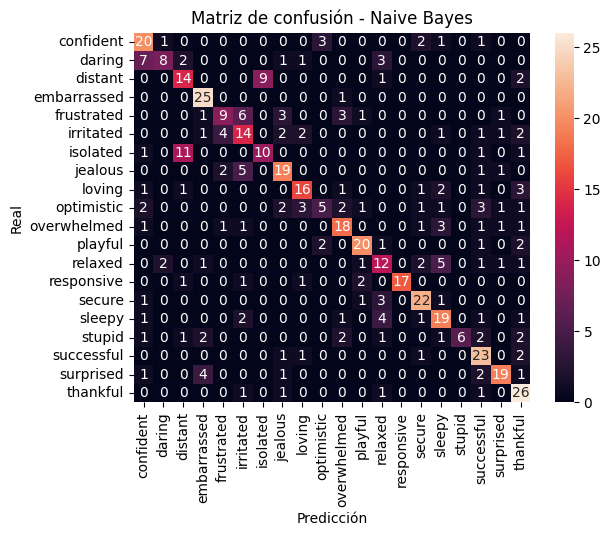

=== SVM lineal ===
Accuracy: 0.7335907335907336
F1 (macro): 0.7291814183969361
              precision    recall  f1-score   support

   confident       0.63      0.68      0.66        28
      daring       0.65      0.50      0.56        22
     distant       0.58      0.58      0.58        26
 embarrassed       0.72      0.88      0.79        26
  frustrated       0.56      0.62      0.59        24
   irritated       0.62      0.54      0.58        28
    isolated       0.64      0.67      0.65        24
     jealous       0.84      0.75      0.79        28
      loving       0.78      0.69      0.73        26
  optimistic       0.61      0.64      0.62        22
 overwhelmed       0.79      0.68      0.73        28
     playful       0.96      0.85      0.90        26
     relaxed       0.57      0.62      0.59        26
  responsive       0.91      0.95      0.93        22
      secure       0.82      0.82      0.82        28
      sleepy       0.68      0.70      0.69        30
  

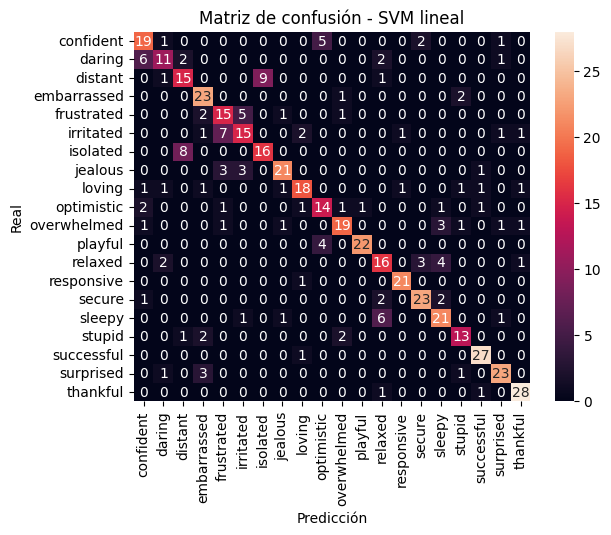

CV F1-macro (SVM) - media: 0.7128 ± 0.0199
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores params: {'clf__C': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Mejor F1-macro (val): 0.6929913849248592
F1-macro (test) del mejor modelo: 0.7276587398680029
CV F1-macro (SVM + oversampling) - media: 0.7134 ± 0.0210
Modelo guardado en 'modelo_sentimiento_es.joblib'


In [19]:
# !pip install scikit-learn imbalanced-learn matplotlib seaborn joblib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1) Datos =====
# Asegúrate de tener df['clean_text'] y df['label']
X = df['clean_text'].astype(str).values
y = df['emotion'].values  # puede ser str o int

# ===== 2) Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 3) Vectorizador (TF-IDF) =====
# Características robustas para tweets: unigrams+bigrams, min_df para ruido, ngram_range=(1,2)
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=3,
    strip_accents='unicode',
    sublinear_tf=True
)

# ===== 4) Baseline 1: Naive Bayes =====
nb_clf = Pipeline([
    ('tfidf', tfidf),
    ('clf', MultinomialNB())
])

nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)

print("=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 (macro):", f1_score(y_test, y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=np.unique(y))
sns.heatmap(cm_nb, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Matriz de confusión - Naive Bayes")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()

# ===== 5) Baseline 2: SVM lineal =====
svm_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("=== SVM lineal ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 (macro):", f1_score(y_test, y_pred_svm, average='macro'))
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y))
sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Matriz de confusión - SVM lineal")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()

# ===== 6) Validación cruzada rápida (SVM) =====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"CV F1-macro (SVM) - media: {scores.mean():.4f} ± {scores.std():.4f}")

# ===== 7) Búsqueda de hiperparámetros (GridSearch) =====
param_grid = {
    'tfidf__min_df': [2, 3, 5],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1, 2, 4]  # regularización de LinearSVC
}
grid = GridSearchCV(
    Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight='balanced', random_state=42))]),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
print("Mejores params:", grid.best_params_)
print("Mejor F1-macro (val):", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("F1-macro (test) del mejor modelo:", f1_score(y_test, y_pred_best, average='macro'))

# ===== 8) Manejo de desbalance (opcional) =====
# Oversampling simple dentro de un pipeline:
from imblearn.pipeline import Pipeline as ImbPipeline
imb_pipeline = ImbPipeline([
    ('tfidf', tfidf),
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', LinearSVC(class_weight=None, random_state=42))  # quitamos balanced porque oversample ya equilibra
])
imb_scores = cross_val_score(imb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"CV F1-macro (SVM + oversampling) - media: {imb_scores.mean():.4f} ± {imb_scores.std():.4f}")

# ===== 9) Guardar el modelo ganador =====
dump(best_model, 'modelo_sentimiento_es.joblib')
print("Modelo guardado en 'modelo_sentimiento_es.joblib'")


In [22]:
# !pip install tensorflow scikit-learn

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

texts = df['clean_text'].astype(str).tolist()
labels = df['emotion'].values

# Si y es string, mapear a índices
if not np.issubdtype(pd.Series(labels).dtype, np.number):
    classes = sorted(pd.Series(labels).unique().tolist())
    cls2id = {c:i for i,c in enumerate(classes)}
    y_idx = np.array([cls2id[c] for c in labels])
else:
    y_idx = labels.astype(int)
num_classes = len(np.unique(y_idx))

# Tokenización
max_words = 40000
tok = Tokenizer(num_words=max_words, oov_token="<unk>")
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)

# Longitud máxima razonable para tweets
maxlen = 60
X_pad = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')
y_cat = to_categorical(y_idx, num_classes=num_classes)

X_tr, X_te, y_tr, y_te = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y_idx, random_state=42)

# CNN 1D
model = models.Sequential([
    layers.Embedding(input_dim=min(max_words, len(tok.word_index)+1), output_dim=128, input_length=maxlen),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_tr, y_tr, validation_split=0.1, epochs=6, batch_size=128, verbose=1)

test_loss, test_acc = model.evaluate(X_te, y_te, verbose=0)
print("Accuracy (test):", round(test_acc, 4))


Epoch 1/6


c:\Users\Alvar\OneDrive\Documentos\SemestreX\Natural Language Process\spanish-twitter-sentiment-nlp\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0589 - loss: 2.9939 - val_accuracy: 0.0673 - val_loss: 2.9930
Epoch 2/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1207 - loss: 2.9426 - val_accuracy: 0.0769 - val_loss: 2.9835
Epoch 3/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1809 - loss: 2.8646 - val_accuracy: 0.1202 - val_loss: 2.9604
Epoch 4/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3441 - loss: 2.7583 - val_accuracy: 0.1346 - val_loss: 2.9226
Epoch 5/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4764 - loss: 2.5390 - val_accuracy: 0.1731 - val_loss: 2.8322
Epoch 6/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6161 - loss: 2.2196 - val_accuracy: 0.2740 - val_loss: 2.6807
Accuracy (test): 0.3185


In [29]:
# !pip install sentence-transformers scikit-learn numpy

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# ===== 1) Modelo de oraciones =====
# Alternativas: "paraphrase-multilingual-MiniLM-L12-v2" o "distiluse-base-multilingual-cased-v1"
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
sbert = SentenceTransformer(model_name)

# ===== 2) Indexación del corpus =====
corpus_texts = df['clean_text'].astype(str).tolist()
corpus_ids = df.index.to_list()  # para recuperar el tweet original
corpus_emb = sbert.encode(corpus_texts, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

# ===== 3) Función de búsqueda =====
def search_similar(query, top_k=5):
    q_emb = sbert.encode([query], convert_to_numpy=True)
    sims = cosine_similarity(q_emb, corpus_emb)[0]  # (N,)
    top_idx = np.argsort(-sims)[:top_k]
    results = []
    for i in top_idx:
        results.append({
            "score": float(sims[i]),
            "id": corpus_ids[i],
            "text": df.loc[corpus_ids[i], 'text'],
            "clean_text": df.loc[corpus_ids[i], 'clean_text'],
            "emotion": df.loc[corpus_ids[i], 'emotion'] if 'emotion' in df.columns else None
        })
    return results

# ===== 4) Ejemplo de uso =====
ejemplo = search_similar("me siento muy feliz con el resultado", top_k=5)
for r in ejemplo:
    print(f"[{r['score']:.3f}] {r['text']}  (sentiment={r['emotion']})")

# ===== 5) Evaluación rápida (precision@k) =====
# Definición: consulta = un documento; relevante si comparte la misma etiqueta (si existe columna 'label')
def precision_at_k(k=5, sample_size=200):
    if 'emotion' not in df.columns:
        raise ValueError("Se necesita df['emotion'] para esta evaluación.")
    rng = np.random.default_rng(42)
    idx_sample = rng.choice(len(df), size=min(sample_size, len(df)), replace=False)
    hits = 0
    total = 0
    for idx in idx_sample:
        q_text = df.iloc[idx]['clean_text']
        q_label = df.iloc[idx]['emotion']
        res = search_similar(q_text, top_k=k+1)  # +1 para saltar el propio doc si aparece
        # quitar el mismo documento si vuelve
        res = [r for r in res if r['id'] != df.index[idx]][:k]
        if len(res) == 0: 
            continue
        rel = sum(1 for r in res if r['emotion'] == q_label)
        hits += rel / k
        total += 1
    return hits/total if total>0 else 0.0

p5 = precision_at_k(k=5, sample_size=300)
print(f"Precision@5 (misma clase como relevancia): {p5:.4f}")


Batches: 100%|██████████| 41/41 [00:16<00:00,  2.43it/s]


[0.676] Hoy pase un día tan alegre y me siento muy agradecida y lo terminé con una bonita noticia.  (sentiment=optimistic)
[0.644] Que día tan bendecido. No puedo ser más feliz  (sentiment=thankful)
[0.590] Ando bien excitado o como se dice cuando te sientes exitoso?  (sentiment=successful)
[0.585] que cojones hago viendo operación triunfo  (sentiment=successful)
[0.577] Ustedes no saben cuán grato es terminar un día de gymn  (sentiment=thankful)
Precision@5 (misma clase como relevancia): 0.1867
